In [2]:
#Склеить изображение (5 х 5)
#Убрать градиенты по краям
#Убрать линии склейки
#Выделить контуры животных
#Найти контур одного и того же животного на всех изображениях
#Отследить изменение площади
#Можно показать, какие части контурв растягиваются / сжимаются
#Отследить перемещение
!pip install opencv-python

     -------------------------------------- 38.2/38.2 MB 452.7 kB/s eta 0:00:00


In [17]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np

img = cv.imread("./data/Well B1_01/2020_02_21_19_01_45_57.tif")

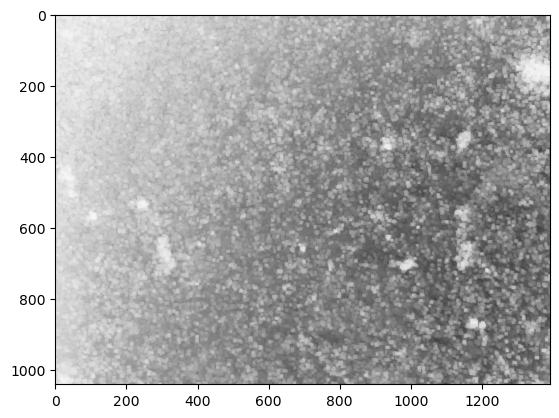

In [54]:
def morph_open(img, morph_size):
    element = cv.getStructuringElement(cv.MORPH_RECT, (2 * morph_size + 1, 2 * morph_size + 1), (morph_size, morph_size))
    return cv.morphologyEx(img, cv.MORPH_OPEN, element)
opened = morph_open(255 - img, 3)
plt.imshow(opened)

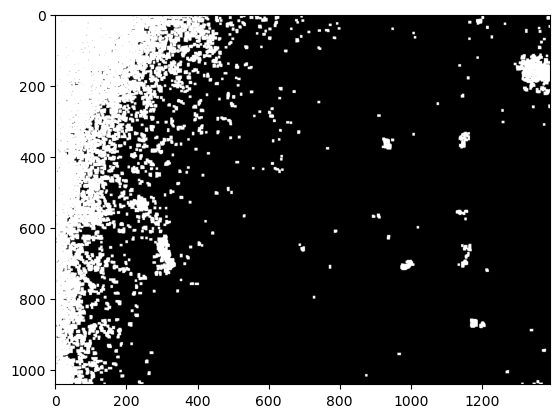

In [55]:
_, thresholded = cv.threshold(opened, 200, 255, cv.THRESH_BINARY)
plt.imshow(thresholded)

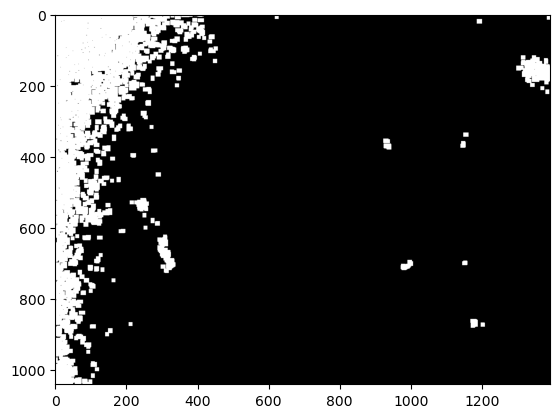

In [56]:
opened2 = morph_open(thresholded, 5)
plt.imshow(opened2)

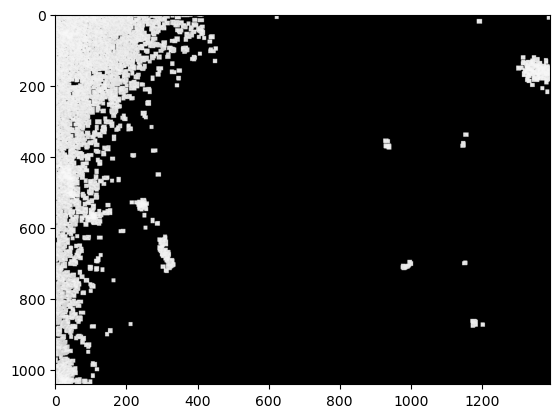

In [61]:
plants = img - img * opened2
plt.imshow(img - plants)

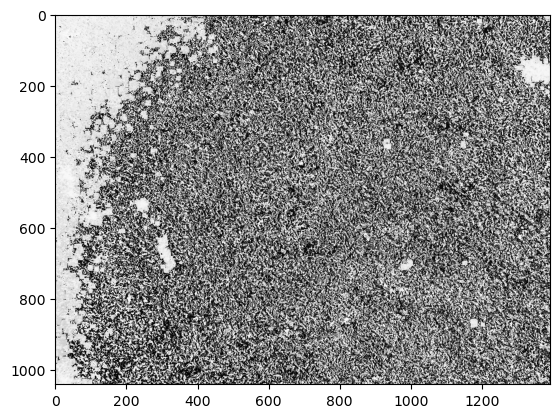

In [64]:
img1 = cv.imread("./data/Well B1_01/2020_02_21_19_03_42_77.tif")
minus_plants = img1 - plants
plt.imshow(minus_plants)

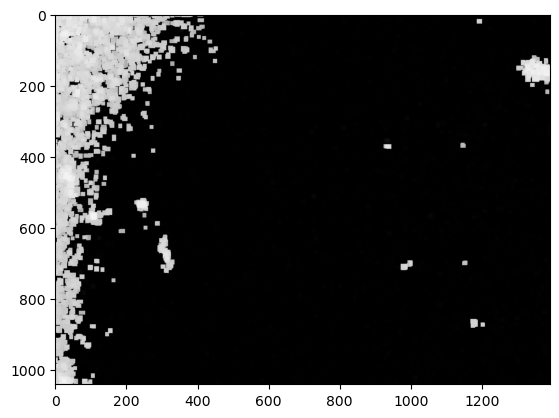

In [68]:
opened3 = morph_open(minus_plants, 5)
plt.imshow(opened3)